In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

from xgboost import plot_importance
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']


missing_cols = ['DP05_0028PE', 'Number of Consumers with CSR AV of 87%', 
                'Average Monthly Advanced CSR Payment for Consumers with 87%', 
                'DP05_0018PE', 'Number of Consumers with CSR (AV of 73%/87%/94%)', 'Total Number of Consumers',
                'Number of Consumers with CSR AV of 73%', 'Number of Consumers with CSR AV of 94%', 'FIPS County Code',
                'Average Monthly Advanced CSR Payment for Consumers with 73%', 
                'Average Monthly Advanced CSR Payment for Consumers with 94%', 
                'DP05_0032PE', 'DP05_0004PE', 'County Name']

#setup y
y_cols = ['Ever Enrolled Count']
    
x_cols = []
for col in df1.columns:
    if col not in y_cols and col not in keys and col not in missing_cols: 
        x_cols.append(col)

print(df1['Ever Enrolled Count'].var())

33778462.88049396


In [3]:
X_train = df1[x_cols]
X_train = X_train/X_train.std()

X_test = df2[x_cols]
X_test = X_test/X_test.std()
X_test = X_test.fillna(0)

y_train = df1[y_cols]
y_test = df2[y_cols]

In [4]:
def get_predictions(model,X_test):
    y_pred = model.predict(X_test)
    y_pred[y_pred < 0] = 0
    return np.array(y_pred).reshape(X_test.shape[0],1)


def plot_prediction(split,y_pred,y_test):
    #setup the data
    
    plt.hist(y_pred[y_test < split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_test < split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()

    plt.hist(y_pred[y_pred > split],label='predictions',alpha=.5,density=True)
    plt.hist(y_test[y_pred > split],label='true',alpha=.5,density=True)
    plt.legend()
    plt.show()
    
    
def plot_importance(X_test,model):
    #use similar code for producing rankings of features according to LASSO
    cols = np.array(X_test.columns)
    importance_raw = model.get_booster().get_score(importance_type='weight')
    importance = []

    for key in importance_raw.keys():
        importance.append([key,importance_raw[key]])

    importance  = pd.DataFrame( importance, columns=['features','score'])
    importance = importance.sort_values('score',ascending=False)

    plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])
    plt.show()

    
def report_error(y_test,y_pred):
    y_test = y_test.copy()
    y_test['error'] = np.abs(y_test - y_pred)**2
    y_test['pred'] = y_pred
    result = y_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('','_x'))
    result  =  result.rename(columns={'Total Number of Consumers':'csr_tot',
                        'Number of Consumers with CSR AV of 94%':'csr_tot_94',
                                     'EHBPercentTotalPremium':'prices'})
    result['shares'] = result['Ever Enrolled Count']/result['DP03_0095E']
    result = result.sort_values('error',ascending=False).head(50)
    #plt.title('20 worst predictions')
    #plt.hist(result['Ever Enrolled Count'],label='true',alpha=.5,density=True)
    #plt.hist(result['pred'],label='pred',alpha=.5,density=True)
    #plt.legend()
    #plt.show()
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    #MetalLevel_Silver
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

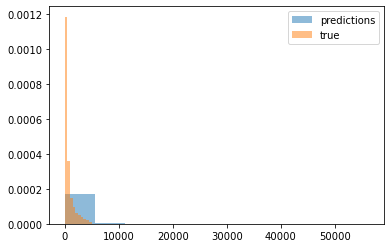

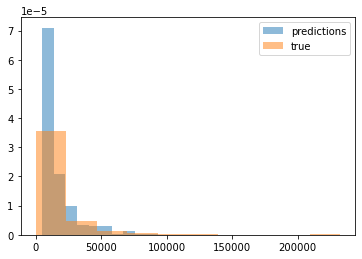

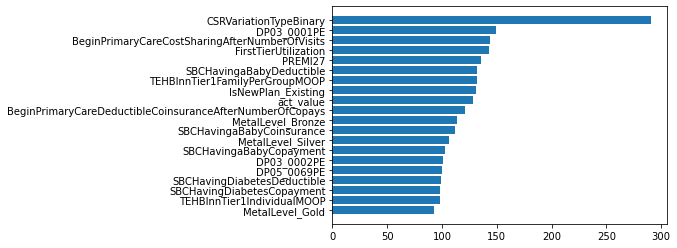

mse 24320758.893233117 r2 0.5173209016114177 var 50387014.83952308


In [5]:
params = [(5,.1,.5,.5)]


for param in params:
    mses = []
    r2s = []
    # not super deep, but uses most of the data at one
    model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=param[0],
                         eta=param[1], subsample=param[2], colsample_bytree=param[3])
    model.fit(X_train, y_train)

    y_pred = get_predictions(model,X_test)
    mse = float( ((y_test - y_pred)**2).mean() )
    r2 = float(  1- mse/y_test.var() )

    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    plot_importance(X_test,model)
            
    #report fit statistics
    mses,r2s = np.array(mses),np.array(r2s)
    print( 'mse', mse ,'r2', 1 - float(mse/y_test.var()), 'var', float(y_test.var()) )

mse 34985990.08449389 r2 0.3056546374910223 var 50387014.83952308


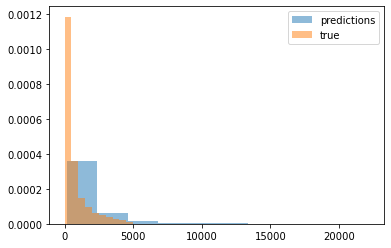

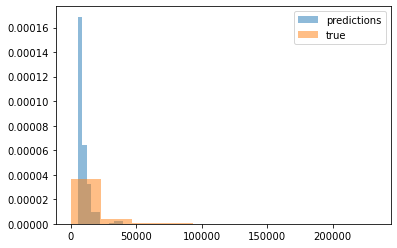

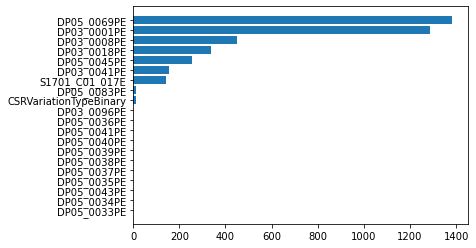

               pred  Ever Enrolled Count      pred_var    enroll_var
State                                                               
AZ     31595.336808        102128.000000           NaN           NaN
IL     29587.281047         41872.000000  17018.539225  30393.368833
NV     21842.262257         25056.500000      6.800799  31748.387368
TX     17980.099902         42825.166667   8554.202938  39331.550971
FL     12639.050977         63285.533333   4997.985506  52147.080269
VA     12098.530594         35581.000000           NaN           NaN
UT     10433.160285         32991.500000   6442.697189  10560.639777
PA      9146.930755         33730.000000   3086.850998   8895.247308
GA      8964.806895         36800.000000   1695.821536  13393.341368
NC      8585.255580         46566.333333   2780.157921  18071.783872
MO      8006.296681         33361.000000           NaN           NaN
OK      6815.664569         29752.500000    524.999415   4468.207750
KS      5704.806589         26915.

In [6]:
# Vary alpha values
a = [250]
for i in a: 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method='elastic_net', alpha=i, L1_wt=1.0)
    y_pred = get_predictions(lasso,np.array(X_test))
    
    mse = float(((y_test - y_pred)**2).mean())
    r2 = float( 1 - mse/y_test.var() )
    print( 'mse', mse ,'r2', 1 - float(mse/y_test.var()), 'var', float(y_test.var()) )
    
    #plot the difference between true and predicted
    split = 5000
    plot_prediction(split,y_pred,y_test)
    
    #also plot important feature
    param_df = pd.DataFrame(np.abs(lasso.params),columns=['score']).sort_values(by=['score'], ascending=False).head(20)
    param_df['features'] = param_df.index
    plt.barh(param_df['features'].iloc[::-1], param_df['score'].iloc[::-1])
    plt.show()
    print(report_error(y_test,y_pred))
    print('==========================================')
    print('==========================================')